**GeoCarb**

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
%cd '/content/gdrive/MyDrive/GeoCarb'
import numpy as np
import pandas as pd

hp = []
nhp = []

hp = np.load('SP_hp.npy')
nhp = np.load('SP_nhp.npy')
lat = np.load('lat.npy')
lon = np.load('lon.npy')
SP_normal = np.load('SP_nor.npy')
XCH4_normal = np.load('XCH4_nor.npy')
XC = np.load('XC.npy')
EM = np.load('EM.npy')
data = pd.read_pickle('completedata.df')

print (hp.shape)

/content/gdrive/MyDrive/GeoCarb


ValueError: ignored

In [6]:
%cd '/content/gdrive/MyDrive/GeoCarb'
import numpy as np
import pandas as pd
data = pd.read_pickle('completedata.pkl')


/content/gdrive/MyDrive/GeoCarb


ValueError: ignored

In [ ]:
print(hp[1].shape)

(2, 5, 5)


In [ ]:
!pip install cartopy
!pip install global-land-mask
import cartopy as ccrs

     |████████████████████████████████| 12.1 MB 4.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 219 kB 65.8 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516258 sha256=6d37845b786959bf4f19961f0cf9caae8f3e86eae1f8e2c22bb584d01bc29923
  Stored in directory: /root/.cache/pip/wheels/98/01/f7/bd10aeb96fe4b518cde5f7c4f5e12c7202f85b7353a5017847
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37324 sha256=b02baf2939b4e70a04f128a4e35c769319bfe1cd615a2cf3c84c25a03ca48f9c
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built cartopy pyshp
     |████████████████████████████████| 1.8 MB 3.6 MB/s 


In [ ]:
from joblib import load, dump
import matplotlib.pyplot as plt
from random import randint
from scipy import ndimage
from sklearn import svm
from global_land_mask import globe
from tqdm import trange

In [ ]:
#Create a land mask
lon_grid, lat_grid = np.meshgrid(lon,lat)
landmask = globe.is_land(lat_grid, lon_grid)

print(landmask.shape)

hotspot5x5= hp.tolist()
non_hp5x5=nhp.tolist()

# Prepare Training and Testing data
train_data = np.concatenate((hp,nhp),axis=0)
x_data = train_data
#Feature Scaling
#x_data = (x_data-np.min(x_data))/(np.max(x_data)-np.min(x_data))
print (np.max(x_data))

# Create Y (Ground truth) 
z1 = np.zeros(len(non_hp5x5))
o1 = np.ones(len(hotspot5x5))
y_data = np.concatenate((o1, z1), axis=0)

x_data.shape




(961, 801)
1.0


(782938, 2, 5, 5)

In [ ]:
print(len(hotspot5x5[0][0]))

5


7355


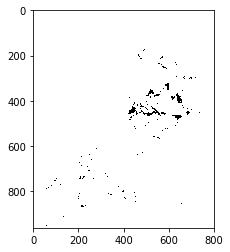

In [ ]:
## TRIAL ON EMISSIONS
from scipy import stats
data = EM[167]
data = data * (10 ** 6)

data[data > 0.001] = 1
data[data != 1] = 0
print(len(np.where(data == 1)[1]))

# z = np.abs(stats.zscore(data1))
import seaborn as sns

#sns.boxplot(z)
plt.imshow(data, cmap='Greys', interpolation='nearest')
# sns.boxplot(z)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=42)
number_of_train = x_train.shape[0]
number_of_test = x_test.shape[0]

x_train_flatten = x_train.reshape(number_of_train,5,5,2)
x_test_flatten = x_test .reshape(number_of_test,5,5,2)
print("X train flatten",x_train_flatten.shape)
print("X test flatten",x_test_flatten.shape)


x_train = x_train_flatten
x_test = x_test_flatten
y_test = y_test
y_train = y_train
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

X train flatten (665497, 5, 5, 2)
X test flatten (117441, 5, 5, 2)
x train:  (665497, 5, 5, 2)
x test:  (117441, 5, 5, 2)
y train:  (665497,)
y test:  (117441,)


In [ ]:
def normalize_SP(data1):
    n1 = (data1 - SP_min)/(SP_max-SP_min)
    return n1

def normalize_XC(data2):
    n2 = (data2-XC_min)/(XC_max - XC_min)
    return n2

def grad(data):
    print(data.shape)
    return np.gradient(data)

def stitch_data(data1,data2):
    s = (2,2)
    d1 = np.array(data1)
    d2 = np.array(data2)
    if d1.shape > s:
        pass
        #ans = np.array(grad(d1))
        #ans = ans.reshape(2*d1.shape[0],d1.shape[1])
    try:
        d3 = np.append(data1,data2, axis =0)
        #d4 = np.append(d3,ans, axis =0)
        return d3
    except:
        x = np.zeros(s)
        return (x)


In [ ]:
def for_cnn(model):
  import cartopy.crs as ccrs
  from matplotlib.patches import Circle
  x_stored = []
  y_stored = []

  a_num = randint(0,248)
  print(a_num)
  img = XC[a_num]
  # surface_p = SP_normal[a_num]
  # dry = XCH4_normal[a_num]
  surface_p = SP_normal[a_num]
  dry = XC[a_num]

  ax = plt.axes(projection=ccrs.PlateCarree())

  plt.contourf(lon, lat, img, 60,
             transform=ccrs.PlateCarree())
  ax.coastlines()
  for ximn in trange(img.shape[0] - 5):
    if ximn % 5 == 0:
        
        for yimn in range(img.shape[1] - 5):
            if yimn % 5 == 0:
                test_img = (stitch_data(dry[ximn:ximn+5, yimn:yimn+5],surface_p[ximn:ximn+5, yimn:yimn+5]))
                try:
                    test_img_flatten = test_img.reshape(1,5,5,2)
                    predict_1 = model.predict(test_img_flatten)
                    #print(np.mean(np.gradient(test_img)))
                except:
                    predict_1 = 0
                
                
                if predict_1 == 1:
                    x_stored.append(ximn)
                    y_stored.append(yimn)

  for xx,yy in zip(x_stored,y_stored):
    ax.plot(lon[yy], lat[xx], 'ro', markersize=2, transform=ccrs.Geodetic())

  plt.show()

In [ ]:
def disp(model):
  import cartopy.crs as ccrs
  from matplotlib.patches import Circle
  x_stored = []
  y_stored = []

  a_num = randint(0,248)
  print(a_num)
  img = XC[a_num]
  surface_p = SP_normal[a_num]
  dry = XCH4_normal[a_num]

  ax = plt.axes(projection=ccrs.PlateCarree())

  plt.contourf(lon, lat, img, 60,
             transform=ccrs.PlateCarree())
  ax.coastlines()
  for ximn in trange(img.shape[0] - 5):
    if ximn % 5 == 0:
        
        for yimn in range(img.shape[1] - 5):
            if yimn % 5 == 0:
                test_img = (stitch_data(dry[ximn:ximn+5, yimn:yimn+5],surface_p[ximn:ximn+5, yimn:yimn+5]))
                try:
                    test_img_flatten = test_img.reshape(1, 50)
                    predict_1 = model.predict(test_img_flatten)
                    #print(np.mean(np.gradient(test_img)))
                except:
                    predict_1 = 0
                
                
                if predict_1 == 1:
                    x_stored.append(ximn)
                    y_stored.append(yimn)

  for xx,yy in zip(x_stored,y_stored):
    ax.plot(lon[yy], lat[xx], 'ro', markersize=2, transform=ccrs.Geodetic())

  plt.show()


In [ ]:
def display_image(model):
  import cartopy.crs as ccrs
  from matplotlib.patches import Circle
  x_stored = []
  y_stored = []

  a_num = randint(0,248)
  print(a_num)
  img = XC[a_num]
  surface_p = SP_normal[a_num]
  dry = XCH4_normal[a_num]

  ax = plt.axes(projection=ccrs.PlateCarree())

  plt.contourf(lon, lat, img, 60,
             transform=ccrs.PlateCarree())
  ax.coastlines()
  for ximn in trange(img.shape[0] - 5):
    if ximn % 5 == 0:
        
        for yimn in range(img.shape[1] - 5):
            if yimn % 5 == 0:
                test_img = (stitch_data(dry[ximn:ximn+5, yimn:yimn+5],surface_p[ximn:ximn+5, yimn:yimn+5]))
                try:
                    test_img_flatten = test_img.reshape(1, 50)
                    predict_1 = model.predict(test_img_flatten)
                    #print(np.mean(np.gradient(test_img)))
                except:
                    predict_1 = 0
                
                
                if predict_1 == 1:
                  if (np.mean(np.gradient(test_img)) > 0.031):
                    x_stored.append(ximn)
                    y_stored.append(yimn)

  for xx,yy in zip(x_stored,y_stored):
    ax.plot(lon[yy], lat[xx], 'ro', markersize=2, transform=ccrs.Geodetic())

  plt.show()


/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


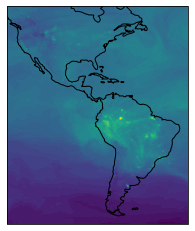

In [ ]:
import cartopy.crs as ccrs
from matplotlib.patches import Circle
x_stored = []
y_stored = []

a_num = randint(0,248)
img = XC[a_num]
surface_p = SP_normal[a_num]
dry = XCH4_normal[a_num]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lon, lat, img, 60,
             transform=ccrs.PlateCarree())
ax.coastlines()
for ximn in range(img.shape[0] - 5):
    if ximn % 5 == 0:
        
        for yimn in range(img.shape[1] - 5):
            if yimn % 5 == 0:
                test_img = (stitch_data(dry[ximn:ximn+5, yimn:yimn+5],surface_p[ximn:ximn+5, yimn:yimn+5]))
                try:
                    test_img_flatten = test_img.reshape(1, 50)
                    predict_1 = sg.predict(test_img_flatten)
                except:
                    predict_1 = 0
                
                
                if predict_1 == 1:
                    x_stored.append(ximn)
                    y_stored.append(yimn)

for xx,yy in zip(x_stored,y_stored):
    ax.plot(lon[yy], lat[xx], 'ro', markersize=5, transform=ccrs.Geodetic())

plt.show()

In [ ]:
# from sklearn import svm
# clf = svm.NuSVC(gamma = 'auto')
# clf.fit(x_train.T,y_train.T.ravel())

# **Neural Network Model**

# CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

In [ ]:
Conv_model = Sequential()

# Adding models to the layer
Conv_model.add(Conv2D(32, (1, 1), activation='relu', padding='same', name='conv_1', 
                 input_shape=(5, 5, 2)))
Conv_model.add(MaxPooling2D((2, 2), name='maxpool_1'))
Conv_model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same', name = 'conv_2'))
Conv_model.add(MaxPooling2D((2, 2), name='maxpool_2'))
Conv_model.add(Conv2D(128, (1,1), activation = 'relu', padding = 'same', name = 'conv_3'))
Conv_model.add(Flatten())
Conv_model.add(Dropout(0.5))
Conv_model.add(Dense(32, activation='relu', name='dense_1'))
Conv_model.add(Dense(16, activation='relu', name='dense_2'))
Conv_model.add(Dense(1, activation='sigmoid', name='output'))


In [ ]:
Conv_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 5, 5, 32)          96        
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 2, 2, 32)          0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 2, 2, 64)          18496     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 1, 1, 64)          0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 1, 1, 128)         8320      
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [ ]:
#compile model using accuracy to measure model performance
Conv_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
#train the model
Conv_model.fit(x_train,y_train.ravel(), epochs=10, batch_size = 64, verbose = 2)

Epoch 1/10
10399/10399 - 51s - loss: 0.3804 - accuracy: 0.8333
Epoch 2/10
10399/10399 - 26s - loss: 0.3365 - accuracy: 0.8600
Epoch 3/10
10399/10399 - 24s - loss: 0.3193 - accuracy: 0.8670
Epoch 4/10
10399/10399 - 24s - loss: 0.3098 - accuracy: 0.8718
Epoch 5/10
10399/10399 - 25s - loss: 0.3064 - accuracy: 0.8728
Epoch 6/10
10399/10399 - 23s - loss: 0.3024 - accuracy: 0.8746
Epoch 7/10
10399/10399 - 24s - loss: 0.2993 - accuracy: 0.8758
Epoch 8/10
10399/10399 - 24s - loss: 0.2952 - accuracy: 0.8776
Epoch 9/10
10399/10399 - 24s - loss: 0.2930 - accuracy: 0.8785
Epoch 10/10
10399/10399 - 25s - loss: 0.2893 - accuracy: 0.8797


184


100%|██████████| 956/956 [39:24<00:00,  2.47s/it]


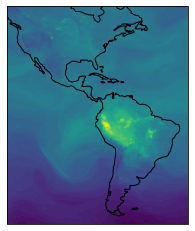

In [ ]:
display_image(Conv_model)

#MODELS

## Logistic Regression


In [ ]:
from sklearn import linear_model
log_reg = linear_model.LogisticRegression(penalty='l2', warm_start= 'true', verbose= 1, max_iter=10000)

log_reg.fit(x_train.T, y_train.T.ravel()).score(x_train.T, y_train.T.ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


0.8049172272752544

151


100%|██████████| 956/956 [00:03<00:00, 272.96it/s]


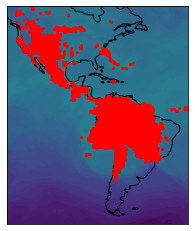

In [ ]:
disp(log_reg)

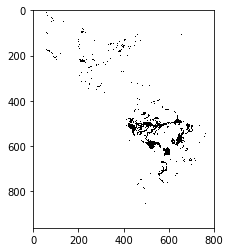

In [ ]:
data = EM[223]

data = data * (10**6)
data[data>0.0005] = 1
data[data<0.02] = 0
data = np.flip(data, axis = 0)
plt.imshow(data, cmap='Greys', interpolation='nearest')

## Support Vector Machine

## Stochastic Gradient Descent

In [ ]:
from sklearn import linear_model
sg = linear_model.SGDClassifier(loss = 'hinge',alpha = 0.0001, max_iter = 10000, verbose = True,n_iter_no_change=10, random_state = 42)
sg.fit(x_train.T, y_train.T.ravel()).score(x_train.T, y_train.T.ravel())

ValueError: ignored

22


100%|██████████| 956/956 [00:04<00:00, 232.16it/s]


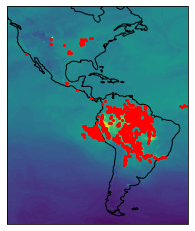

In [ ]:
display_image(sg)

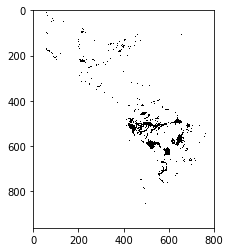

In [ ]:
data = EM[33]

data = data * (10**6)
data[data>0.0005] = 1
data[data<0.02] = 0
data = np.flip(data, axis = 0)
plt.imshow(data, cmap='Greys', interpolation='nearest')

## Custom Neural Network

In [ ]:


# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.5.0


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), input_shape = (5,5,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.fit(x_train,y_train.ravel(), epochs=10)

Epoch 1/10
20797/20797 [==============================] - 44s 2ms/step - loss: 0.3819 - accuracy: 0.8317
Epoch 2/10
20797/20797 [==============================] - 45s 2ms/step - loss: 0.3565 - accuracy: 0.8463
Epoch 3/10
20797/20797 [==============================] - 44s 2ms/step - loss: 0.3477 - accuracy: 0.8503
Epoch 4/10
20797/20797 [==============================] - 43s 2ms/step - loss: 0.3367 - accuracy: 0.8558
Epoch 5/10
20797/20797 [==============================] - 45s 2ms/step - loss: 0.3262 - accuracy: 0.8609
Epoch 6/10
20797/20797 [==============================] - 44s 2ms/step - loss: 0.3219 - accuracy: 0.8631
Epoch 7/10
20797/20797 [==============================] - 45s 2ms/step - loss: 0.3186 - accuracy: 0.8648
Epoch 8/10
20797/20797 [==============================] - 44s 2ms/step - loss: 0.3160 - accuracy: 0.8658
Epoch 9/10
20797/20797 [==============================] - 44s 2ms/step - loss: 0.3138 - accuracy: 0.8665
Epoch 10/10
20797/20797 [==============================

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test.ravel(), verbose=2)

print('\nTest accuracy:', test_acc)

3671/3671 - 4s - loss: 0.3103 - accuracy: 0.8691

Test accuracy: 0.869117259979248


In [ ]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

100%|██████████| 956/956 [38:34<00:00,  2.42s/it]


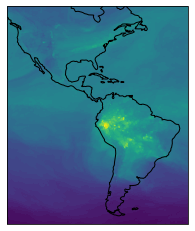

In [ ]:
import cartopy.crs as ccrs
from matplotlib.patches import Circle
import random
x_stored = []
y_stored = []

a_num = random.randint(0,248)
img = XC[a_num]
surface_p = SP_normal[a_num]
dry = XCH4_normal[a_num]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lon, lat, img, 60,
             transform=ccrs.PlateCarree())
ax.coastlines()
for ximn in trange(img.shape[0] - 5):
    if ximn % 5 == 0:
        
        for yimn in range(img.shape[1] - 5):
            if yimn % 5 == 0:
                test_img = (stitch_data(dry[ximn:ximn+5, yimn:yimn+5],surface_p[ximn:ximn+5, yimn:yimn+5]))
                try:
                    test_img_flatten = test_img.reshape(5,5,2)
                    predictions = probability_model.predict(test_img_flatten)
                    predict_1 = np.argmax(predictions)
                except:
                    predict_1 = 0
                
                
                if predict_1 == 1:
                    x_stored.append(ximn)
                    y_stored.append(yimn)

for xx,yy in zip(x_stored,y_stored):
    ax.plot(lon[yy], lat[xx], 'ro', markersize=2, transform=ccrs.Geodetic())

plt.show()

## The Gradient Map

106


100%|██████████| 956/956 [00:07<00:00, 128.55it/s]


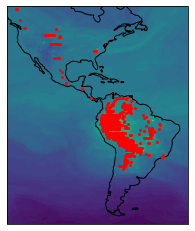

In [ ]:
import cartopy.crs as ccrs
from matplotlib.patches import Circle
x_stored = []
y_stored = []

a_num = randint(0,248)
print(a_num)
img = XC[a_num]
surface_p = SP_normal[a_num]
dry = XCH4_normal[a_num]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lon, lat, img, 60,
             transform=ccrs.PlateCarree())
ax.coastlines()
for ximn in trange(img.shape[0] - 5):
    if ximn % 5 == 0:
        
        for yimn in range(img.shape[1] - 5):
            if yimn % 5 == 0:
                test_img = (stitch_data(dry[ximn:ximn+5, yimn:yimn+5],surface_p[ximn:ximn+5, yimn:yimn+5]))
                try:
                    test_img_flatten = test_img.reshape(1, 50)
                    if (np.mean(np.gradient(np.gradient(test_img))) > -0.02):
                       if (np.mean(np.gradient(test_img)) > 0.031):
                         predict_1 = sg.predict(test_img_flatten)
                    else:
                      predict_1 = 0
                    #print(np.mean(np.gradient(np.gradient(test_img))))
                except:
                    predict_1 = 0
                
                
                if predict_1 == 1:
                  
                    x_stored.append(ximn)
                    y_stored.append(yimn)

for xx,yy in zip(x_stored,y_stored):
    ax.plot(lon[yy], lat[xx], 'ro', markersize=2, transform=ccrs.Geodetic())

plt.show()

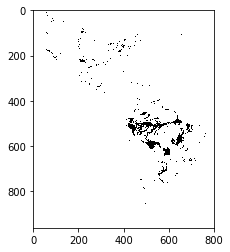

In [ ]:
data = EM[145]

data = data * (10**6)
data[data>0.0005] = 1
data[data<0.02] = 0
data = np.flip(data, axis = 0)
plt.imshow(data, cmap='Greys', interpolation='nearest')

108


100%|██████████| 956/956 [00:02<00:00, 360.07it/s]


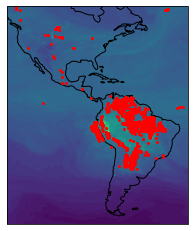

In [ ]:
display_image(sg)

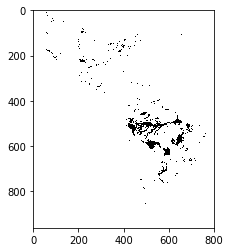

In [ ]:
data = EM[108]

data = data * (10**6)
data[data>0.0005] = 1
data[data<0.02] = 0
data = np.flip(data, axis = 0)
here = (np.where(data == 1))
plt.imshow(data, cmap='Greys', interpolation='nearest')

In [ ]:
for i in here:
  print(i)

[ 11  11  11 ... 903 903 903]
[ 57  58  59 ... 491 493 494]


# Using only methane conc.

In [ ]:
print(len(XC))
for i in trange(len(XC)):
  image = XC[i]
  cutx = np.linspace(0,950, 96)
  cuty = np.linspace(0,790,80)
  tmp = np.meshgrid(cutx,cuty)
print(tmp[1])

100%|██████████| 248/248 [00:00<00:00, 10609.61it/s]

248
[[  0.   0.   0. ...   0.   0.   0.]
 [ 10.  10.  10. ...  10.  10.  10.]
 [ 20.  20.  20. ...  20.  20.  20.]
 ...
 [770. 770. 770. ... 770. 770. 770.]
 [780. 780. 780. ... 780. 780. 780.]
 [790. 790. 790. ... 790. 790. 790.]]


# The gradient method (dissected)

In [ ]:

import cartopy.crs as ccrs
from matplotlib.patches import Circle
x_stored = []
y_stored = []

a_num = randint(0,248)
print(a_num)
img = XC[a_num]
surface_p = SP_normal[a_num]
dry = XCH4_normal[a_num]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lon, lat, img, 60,
             transform=ccrs.PlateCarree())
ax.coastlines()
for ximn in trange(img.shape[0] - 5):
    if ximn % 5 == 0:
        
        for yimn in range(img.shape[1] - 5):
            if yimn % 5 == 0:
                #test_img = (stitch_data(dry[ximn:ximn+5, yimn:yimn+5],surface_p[ximn:ximn+5, yimn:yimn+5]))
                test_img = dry[ximn:ximn+5, yimn:yimn+5]
                try:
                  grad_img = np.gradient(test_img)
                  double_grad_img = np.gradient(grad_img)
                  

                    test_img_flatten = test_img.reshape(1, 50)
                    if (np.mean(np.gradient(np.gradient(test_img))) > -0.02):
                       if (np.mean(np.gradient(test_img)) > 0.031):
                         predict_1 = sg.predict(test_img_flatten)
                    else:
                      predict_1 = 0
                    #print(np.mean(np.gradient(np.gradient(test_img))))
                except:
                    predict_1 = 0
                
                
                if predict_1 == 1:
                  
                    x_stored.append(ximn)
                    y_stored.append(yimn)

for xx,yy in zip(x_stored,y_stored):
    ax.plot(lon[yy], lat[xx], 'ro', markersize=2, transform=ccrs.Geodetic())

plt.show()

In [ ]:
## Gradient of the image 

img = XC[213]
img = img * (10 ** 12)
subset = img[440:445, 540:545]

## Normalization
subset = (subset - np.min(subset))/(np.max(subset) - np.min(subset))
print(subset.shape)

# First Gradient
grad_x = np.gradient(subset, axis=0)
grad_y = np.gradient(subset, axis=1)
print('####*** Gradient in X-axis ***####')
print(grad_x)


# Second Gradient
grad_xx = np.gradient(grad_x, axis=0)
grad_yy = np.gradient(grad_y, axis=1)
# Cross derivative (grad_xy)
print('   ')
print('####*** Gradient-2 in X-axis ***####')
print(grad_xx)

print('   ')
print('####*** Gradient in Y-axis ***####')
print(grad_y)

print('   ')
print('####*** Gradient-2 in Y-axis ***####')
print(grad_yy)

print('   ')
print('   ')
print('   ')
print('mean of the original file = ' ,np.mean(subset))
print('mean of the first grad in x direction = ' ,np.mean(grad_x))
print('mean of the Second grad in x direction = ' ,np.mean(grad_xx))
print('mean of the first grad in y direction = ' ,np.mean(grad_y))
print('mean of the Second grad in y direction = ' ,np.mean(grad_yy))

print('   ')
print('   ')
print('   ')

print('max of the original file = ' ,np.max(subset))
print('max of the first grad in x direction = ' ,np.max(grad_x))
print('max of the Second grad in x direction = ' ,np.max(grad_xx))
print('max of the first grad in y direction = ' ,np.max(grad_y))
print('max of the Second grad in y direction = ' ,np.max(grad_yy))

(5, 5)
####*** Gradient in X-axis ***####
[[-0.00384376 -0.06404529 -0.03752337 -0.05159983 -0.12008103]
 [-0.15451901 -0.1470133  -0.10576044 -0.1192032  -0.1437461 ]
 [-0.2469198  -0.14450966 -0.09911178 -0.111417   -0.12442863]
 [ 0.11794099  0.15684604  0.16526595  0.16200395  0.09849366]
 [ 0.42452732  0.37273011  0.35475795  0.36003532  0.27843341]]
   
####*** Gradient-2 in X-axis ***####
[[-0.15067525 -0.082968   -0.06823707 -0.06760337 -0.02366507]
 [-0.12153802 -0.04023218 -0.0307942  -0.02990858 -0.0021738 ]
 [ 0.13623     0.15192967  0.13551319  0.14060357  0.12111988]
 [ 0.33572356  0.25861988  0.22693486  0.23572616  0.20143102]
 [ 0.30658633  0.21588406  0.189492    0.19803137  0.17993975]]
   
####*** Gradient in Y-axis ***####
[[-0.24803657 -0.22129129 -0.14281114 -0.09423956 -0.09740287]
 [-0.30823811 -0.2381311  -0.13658841 -0.13551839 -0.16588406]
 [-0.23302514 -0.17253272 -0.11500104 -0.13222522 -0.14648868]
 [-0.10341783 -0.09032308 -0.10349574 -0.16083524 -0.1919

# Divide and Predict